In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/FOOD30V2/Images /content/

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Layer, Conv2D, Reshape, Multiply, Add, Activation, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset path
dataset_dir = '/content/Images'
train_folder = os.path.join(dataset_dir, 'Train')
test_folder = os.path.join(dataset_dir, 'Test')
val_folder = os.path.join(dataset_dir, 'Validate')

In [ ]:
#Tạo dataframe từ thư mục ảnh
def get_dataframe_from_folder(folder_path):
    filepaths = []
    labels = []
    class_names = sorted(os.listdir(folder_path))  # sort để đảm bảo đúng thứ tự
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            filepaths.append(fpath)
            labels.append(class_name)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_df = get_dataframe_from_folder(train_folder)
test_df = get_dataframe_from_folder(test_folder)
valid_df = get_dataframe_from_folder(val_folder)

print("Train:", len(train_df), " Valid:", len(valid_df), " Test:", len(test_df))
print("Số lớp:", train_df['labels'].nunique())


Số lượng ảnh theo từng lớp:
labels
Banh beo             461
Banh bot loc         487
Banh can             522
Banh canh            677
Banh chung           353
Banh cuon            802
Banh duc             461
Banh gio             447
Banh khot            585
Banh mi              934
Banh pia             310
Banh tet             478
Banh trang nuong     554
Banh xeo             821
Bun bo Hue          1087
Bun dau mam tom      640
Bun mam              543
Bun rieu             806
Bun thit nuong       522
Ca kho to            473
Canh chua            577
Cao lau              432
Chao long            751
Com tam              659
Goi cuon             604
Hu tieu              686
Mi quang             619
Nem chua             379
Pho                  570
Xoi xeo              366
Name: count, dtype: int64


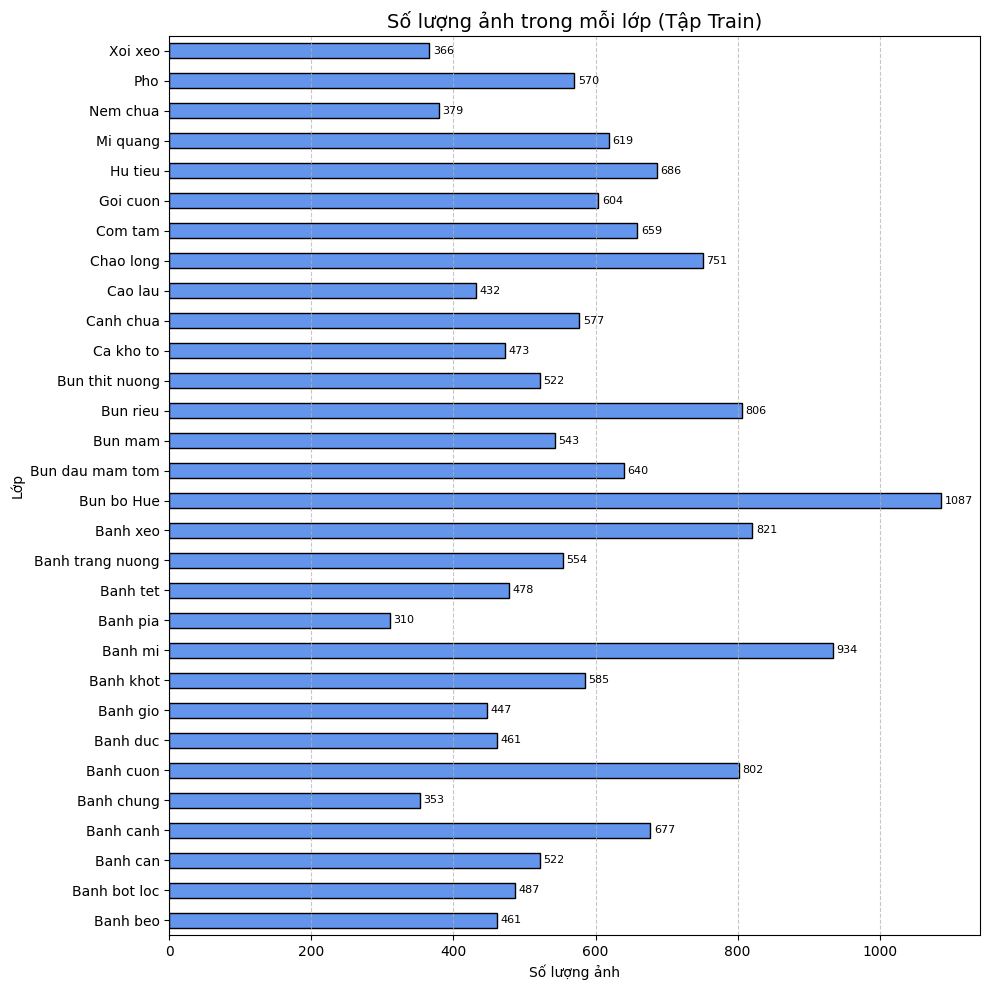

In [5]:
# Thống kê số lượng ảnh theo lớp
train_label_counts = train_df['labels'].value_counts().sort_index()
print("Số lượng ảnh theo từng lớp:")
print(train_label_counts)


# Vẽ biểu đồ thanh theo chiều dọc (horizontal bar)
plt.figure(figsize=(10, 10))
train_label_counts.plot(kind='barh', color='cornflowerblue', edgecolor='black')
# Hiển thị số lượng trên mỗi thanh
for i, v in enumerate(train_label_counts):
    plt.text(v + 5, i, str(v), va='center', fontsize=8)

plt.title("Số lượng ảnh trong mỗi lớp (Tập Train)", fontsize=14)
plt.xlabel("Số lượng ảnh")
plt.ylabel("Lớp")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




In [6]:
def mixup_generator(generator, alpha=0.2):
    while True:
        x_batch, y_batch = next(generator)
        batch_size = x_batch.shape[0]

        # Shuffle batch
        indices = np.random.permutation(batch_size)
        x_batch2 = x_batch[indices]
        y_batch2 = y_batch[indices]

        lam = np.random.beta(alpha, alpha, batch_size)

        lam_x = lam.reshape(batch_size, 1, 1, 1)
        lam_y = lam.reshape(batch_size, 1)

        x_mixed = lam_x * x_batch + (1 - lam_x) * x_batch2
        y_mixed = lam_y * y_batch + (1 - lam_y) * y_batch2

        yield x_mixed, y_mixed

In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Cấu hình
img_size = (224, 224)
batch_size = 32

# Augmentation + Normalize cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Chỉ normalize cho validation/test
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator từ DataFrame
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)
mixup_train_generator = mixup_generator(train_gen, alpha=0.2)

valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# Lấy danh sách tên lớp
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Tính class weights để dùng trong model.fit()
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['labels']),
    y=train_df['labels']
)
class_weights = dict(zip(np.unique(train_df['labels']), class_weights_array))

# In ra class weights
print("Class Weights:", class_weights)


Found 17606 validated image filenames belonging to 30 classes.
Found 2513 validated image filenames belonging to 30 classes.
Found 4942 validated image filenames belonging to 30 classes.
Class Weights: {'Banh beo': np.float64(1.2730296456977586), 'Banh bot loc': np.float64(1.2050650239561944), 'Banh can': np.float64(1.1242656449553001), 'Banh canh': np.float64(0.8668636139832595), 'Banh chung': np.float64(1.6625118035882909), 'Banh cuon': np.float64(0.7317539484621779), 'Banh duc': np.float64(1.2730296456977586), 'Banh gio': np.float64(1.3129008202833705), 'Banh khot': np.float64(1.0031908831908831), 'Banh mi': np.float64(0.6283369022127052), 'Banh pia': np.float64(1.8931182795698924), 'Banh tet': np.float64(1.2277545327754533), 'Banh trang nuong': np.float64(1.0593261131167269), 'Banh xeo': np.float64(0.7148193260251725), 'Bun bo Hue': np.float64(0.5398957375038331), 'Bun dau mam tom': np.float64(0.9169791666666667), 'Bun mam': np.float64(1.0807857581338245), 'Bun rieu': np.float64(0.

--- Hiển thị các phép tăng cường riêng biệt dựa trên ảnh gốc: Banh beo ---


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

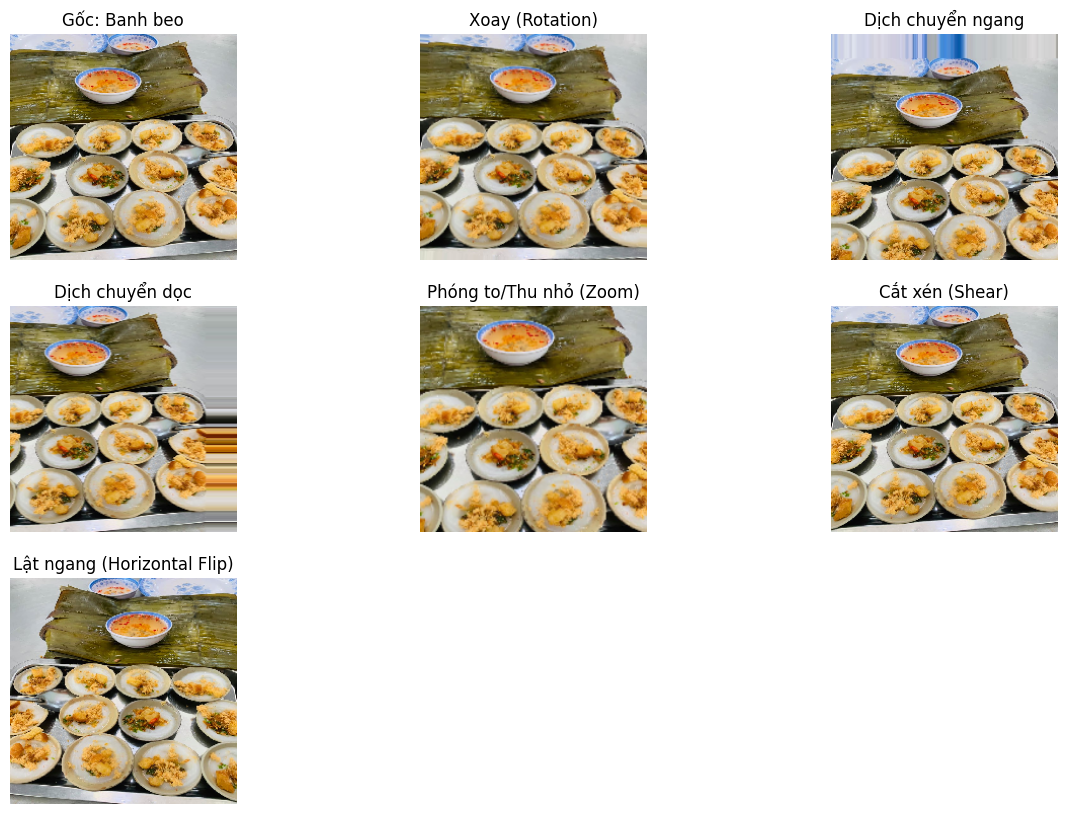

In [25]:

img_size = (224, 224)

# Lấy một ảnh mẫu từ tập huấn luyện để hiển thị
# Chọn ảnh đầu tiên trong train_df
sample_image_path = train_df['filepaths'].iloc[0]
sample_image_label = train_df['labels'].iloc[0]

# Đọc ảnh và resize về kích thước mong muốn (224x224)
original_image = image.load_img(sample_image_path, target_size=img_size)
original_image_array = image.img_to_array(original_image)
# Thêm chiều batch (1, 224, 224, 3)
original_image_array = np.expand_dims(original_image_array, axis=0)
# Chuẩn hóa ảnh gốc cho mục đích hiển thị (giống như rescale=1./255)
original_image_display = original_image_array[0] / 255.0

print(f"--- Hiển thị các phép tăng cường riêng biệt dựa trên ảnh gốc: {sample_image_label} ---")

plt.figure(figsize=(15, 10))

# 1. Ảnh gốc
plt.subplot(3, 3, 1)
plt.imshow(original_image_display)
plt.title(f"Gốc: {sample_image_label}")
plt.axis('off')

# Định nghĩa các ImageDataGenerator cho từng phép tăng cường riêng biệt
# (Chỉ bao gồm rescale để đảm bảo hiển thị đúng dải màu)
# base_datagen = ImageDataGenerator(rescale=1./255) # Không cần dùng trực tiếp cái này nữa

# 2. Xoay (rotation_range=20)
rot_datagen = ImageDataGenerator(rotation_range=20, rescale=1./255)
rot_gen = rot_datagen.flow(original_image_array, batch_size=1, shuffle=False)
plt.subplot(3, 3, 2)
plt.imshow(next(rot_gen)[0]) # Sửa từ rot_gen.next()[0] sang next(rot_gen)[0]
plt.title("Xoay (Rotation)")
plt.axis('off')

# 3. Dịch chuyển chiều rộng (width_shift_range=0.2)
ws_datagen = ImageDataGenerator(width_shift_range=0.2, rescale=1./255)
ws_gen = ws_datagen.flow(original_image_array, batch_size=1, shuffle=False)
plt.subplot(3, 3, 3)
plt.imshow(next(ws_gen)[0]) # Sửa
plt.title("Dịch chuyển ngang")
plt.axis('off')

# 4. Dịch chuyển chiều cao (height_shift_range=0.2)
hs_datagen = ImageDataGenerator(height_shift_range=0.2, rescale=1./255)
hs_gen = hs_datagen.flow(original_image_array, batch_size=1, shuffle=False)
plt.subplot(3, 3, 4)
plt.imshow(next(hs_gen)[0]) # Sửa
plt.title("Dịch chuyển dọc")
plt.axis('off')

# 5. Phóng to (zoom_range=0.2)
zoom_datagen = ImageDataGenerator(zoom_range=0.2, rescale=1./255)
zoom_gen = zoom_datagen.flow(original_image_array, batch_size=1, shuffle=False)
plt.subplot(3, 3, 5)
plt.imshow(next(zoom_gen)[0]) # Sửa
plt.title("Phóng to/Thu nhỏ (Zoom)")
plt.axis('off')

# 6. Cắt xén/Kéo giãn (shear_range=0.2)
shear_datagen = ImageDataGenerator(shear_range=0.2, rescale=1./255)
shear_gen = shear_datagen.flow(original_image_array, batch_size=1, shuffle=False)
plt.subplot(3, 3, 6)
plt.imshow(next(shear_gen)[0]) # Sửa
plt.title("Cắt xén (Shear)")
plt.axis('off')

# 7. Lật ngang (horizontal_flip=True)
flip_datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./255)
flip_gen = flip_datagen.flow(original_image_array, batch_size=1, shuffle=False)
plt.subplot(3, 3, 7)
plt.imshow(next(flip_gen)[0]) # Sửa
plt.title("Lật ngang (Horizontal Flip)")
plt.axis('off')

In [9]:
# --- CBAM Module ---
class CBAM(Layer):
    def __init__(self, filters, reduction_ratio=16,  **kwargs):
        super(CBAM, self).__init__()
        self.filters = filters
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.shared_dense_one = Dense(self.filters // self.reduction_ratio, activation='relu', use_bias=True)
        self.shared_dense_two = Dense(self.filters, use_bias=True)
        self.conv_spatial = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', use_bias=False)

    def call(self, input_tensor):
        # Tính trung bình và max theo kênh → vector dạng (batch, C)
        avg_pool = GlobalAveragePooling2D()(input_tensor)
        max_pool = GlobalMaxPooling2D()(input_tensor)

        # Đưa về dạng (batch, 1, 1, C) để phù hợp với Dense layers
        avg_pool = Reshape((1,1,self.filters))(avg_pool)
        max_pool = Reshape((1,1,self.filters))(max_pool)

        # Qua shared MLP: giảm → tăng chiều
        mlp_avg = self.shared_dense_two(self.shared_dense_one(avg_pool))
        mlp_max = self.shared_dense_two(self.shared_dense_one(max_pool))

        # Cộng lại và qua sigmoid → attention vector theo từng channel
        channel_attention = Activation('sigmoid')(Add()([mlp_avg, mlp_max]))
        # Nhân attention với đầu vào → tăng cường kênh quan trọng
        channel_refined = Multiply()([input_tensor, channel_attention])

        # Tính trung bình và max theo chiều kênh → còn lại mỗi pixel 1 giá trị
        avg_pool_spatial = K.mean(channel_refined, axis=-1, keepdims=True)
        max_pool_spatial = K.max(channel_refined, axis=-1, keepdims=True)

        concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial]) # Ghép 2 ảnh trung bình và max lại theo kênh → shape (H, W, 2)
        spatial_attention = self.conv_spatial(concat)# Áp dụng conv 7x7 + sigmoid → spatial attention map (H, W, 1)
        refined_feature = Multiply()([channel_refined, spatial_attention])# Nhân attention map với feature map đầu vào → tăng cường vùng quan trọng
        return refined_feature


In [10]:
import tensorflow as tf
from keras.losses import Loss

class FocalLossWithSmoothing(Loss):
    def __init__(self, gamma=2., alpha=0.25, label_smoothing=0.1):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Apply label smoothing
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - self.label_smoothing) * y_true + self.label_smoothing / num_classes

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = self.alpha * tf.pow(1 - y_pred, self.gamma)
        focal_loss = weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))


In [11]:

# Giả sử img_size = (224, 224)
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
base_model.trainable = False #đóng băng DenseNet ở phase 1 (chỉ huấn luyện phần trên cùng)

cbam_output = CBAM(filters=base_model.output_shape[-1])(base_model.output)
x = GlobalAveragePooling2D()(cbam_output) #giảm chiều dữ liệu còn vector đặc trưng
output = Dense(num_classes, activation='softmax')(x)#  lớp phân loại ra số lớp num_classes
model = Model(inputs=base_model.input, outputs=output)

loss_fn = FocalLossWithSmoothing(gamma=2.0, alpha=0.25, label_smoothing=0.1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_fn, metrics=['accuracy'])

# Callbacks phase 1
checkpoint_path = "/content/drive/MyDrive/FOOD30V2/checkpoint/densenet169.weights.h5"
epoch_file = "/content/drive/MyDrive/FOOD30V2/checkpoint/densenet169.txt"

early_stopping_phase1 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

class SaveEpochCallback(Callback):
    def __init__(self, epoch_file):
        self.epoch_file = epoch_file
    def on_epoch_end(self, epoch, logs=None):
        with open(self.epoch_file, "w") as f:
            f.write(str(epoch + 1))

#Tạo callback để lưu checkpoint và epoch
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True, #chỉ lưu trọng số, không lưu cấu trúc
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

#Tải sô lượng epoch đã train
initial_epoch = 0
if os.path.exists(epoch_file):
    with open(epoch_file, "r") as f:
        initial_epoch = int(f.read())

#Tải lại model nếu có checkpoint
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Đã tải checkpoint từ file.")
history = model.fit(
    train_gen,
    validation_data= valid_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=20,
    initial_epoch=initial_epoch,
    callbacks=[checkpoint_cb, SaveEpochCallback(epoch_file), early_stopping_phase1],
    class_weight=class_weights
)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Đã tải checkpoint từ file.


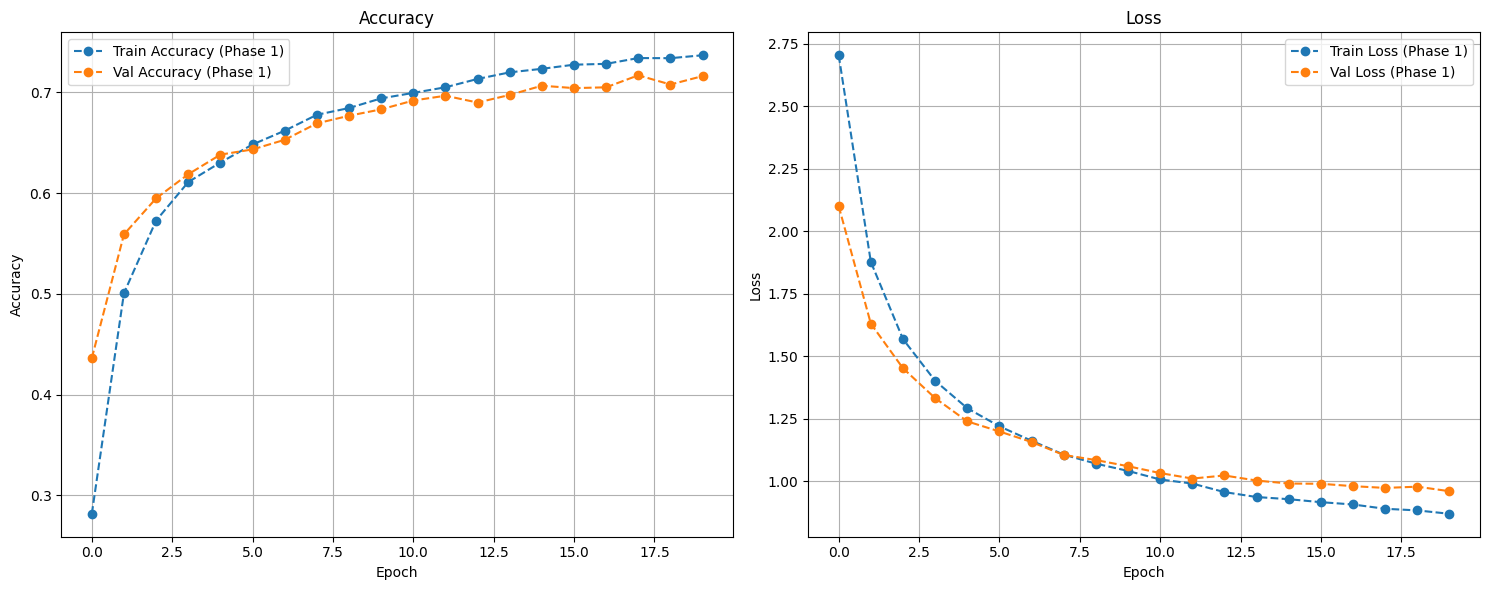

In [27]:
import json
import matplotlib.pyplot as plt
import os

history_file_phase1 = "/content/drive/MyDrive/FOOD30V2/checkpoint1/history_phase1.json"

def load_history_from_json(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            data = json.load(f)
        history_dict = {}
        if data: # Đảm bảo data không rỗng
            for key in data[0].keys():
                history_dict[key] = [d[key] for d in data]
        return history_dict
    return None

history_phase1_loaded = load_history_from_json(history_file_phase1)


if history_phase1_loaded is not None :
    plt.figure(figsize=(15, 6))

    # --- Biểu đồ Accuracy ---
    plt.subplot(1, 2, 1)
    if history_phase1_loaded:
        plt.plot(history_phase1_loaded.get('accuracy', []), label='Train Accuracy (Phase 1)', marker='o', linestyle='--')
        plt.plot(history_phase1_loaded.get('val_accuracy', []), label='Val Accuracy (Phase 1)', marker='o', linestyle='--')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Biểu đồ Loss ---
    plt.subplot(1, 2, 2)
    if history_phase1_loaded:
        plt.plot(history_phase1_loaded.get('loss', []), label='Train Loss (Phase 1)', marker='o', linestyle='--')
        plt.plot(history_phase1_loaded.get('val_loss', []), label='Val Loss (Phase 1)', marker='o', linestyle='--')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print('Không tìm thấy lịch sử train để vẽ biểu đồ.')

In [12]:
# --- Fine-tune toàn bộ ---
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_ckpt_path = "/content/drive/MyDrive/FOOD30V2/finetune/densenet169.weights.h5"
fine_epoch_file = "/content/drive/MyDrive/FOOD30V2/finetune/densenet169.txt"

class SaveFineEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(fine_epoch_file, "w") as f:
            f.write(str(epoch + 1))

fine_checkpoint_cb = ModelCheckpoint(
    filepath=fine_ckpt_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

fine_initial_epoch = 0
if os.path.exists(fine_epoch_file):
    with open(fine_epoch_file, "r") as f:
        fine_initial_epoch = int(f.read())

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

if os.path.exists(fine_ckpt_path):
    model.load_weights(fine_ckpt_path)
    print("Đã tải checkpoint từ file.")

history_finetune = model.fit(
    mixup_train_generator,
    validation_data=valid_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=34,
    initial_epoch=fine_initial_epoch,
    callbacks=[fine_checkpoint_cb, SaveFineEpochCallback(), early_stopping]
)

Đã tải checkpoint từ file.


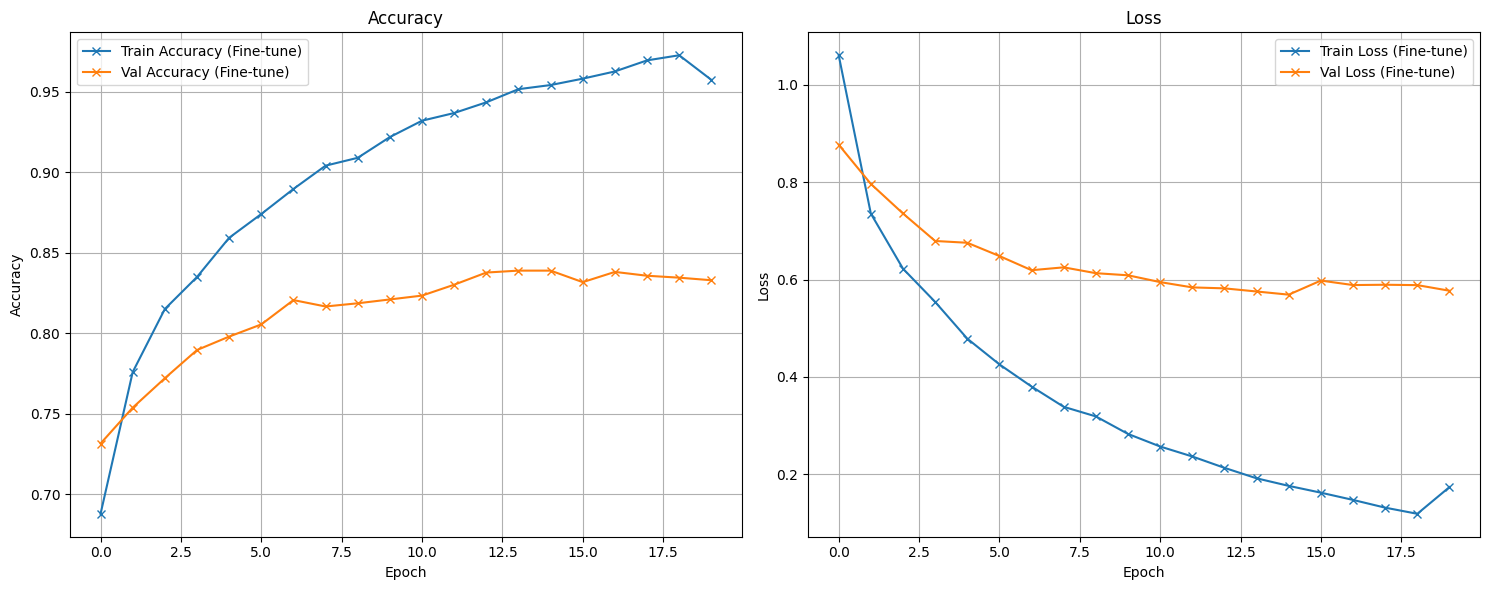

In [28]:
history_file_finetune = "/content/drive/MyDrive/FOOD30V2/finetune1/history_finetune.json"
history_finetune_loaded = load_history_from_json(history_file_finetune)
if history_finetune_loaded is not None:
  plt.figure(figsize=(15, 6))

  # --- Biểu đồ Accuracy ---
  plt.subplot(1, 2, 1)
  if history_finetune_loaded:
        plt.plot(history_finetune_loaded.get('accuracy', []), label='Train Accuracy (Fine-tune)', marker='x')
        plt.plot(history_finetune_loaded.get('val_accuracy', []), label='Val Accuracy (Fine-tune)', marker='x')
        plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # --- Biểu đồ Loss ---
  plt.subplot(1, 2, 2)
  if history_finetune_loaded:
        # epochs_finetune = [e + total_epochs_phase1 for e in range(len(history_finetune_loaded.get('loss', [])))]
        plt.plot(history_finetune_loaded.get('loss', []), label='Train Loss (Fine-tune)', marker='x')
        plt.plot(history_finetune_loaded.get('val_loss', []), label='Val Loss (Fine-tune)', marker='x')

  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
else:
    print('Không tìm thấy lịch sử train để vẽ biểu đồ.')

155/155 ━━━━━━━━━━━━━━━━━━━━ 109s 556ms/step

Classification Report:
                  precision    recall  f1-score   support

        Banh beo       0.96      0.85      0.90       122
    Banh bot loc       0.71      0.89      0.79       133
        Banh can       0.93      0.86      0.89       145
       Banh canh       0.72      0.70      0.71       185
      Banh chung       0.86      0.94      0.90       102
       Banh cuon       0.83      0.91      0.87       221
        Banh duc       0.84      0.66      0.74       122
        Banh gio       0.90      0.88      0.89       125
       Banh khot       0.91      0.90      0.90       164
         Banh mi       0.96      0.97      0.96       265
        Banh pia       0.92      0.98      0.95        89
        Banh tet       0.91      0.88      0.90       132
Banh trang nuong       0.96      0.87      0.91       154
        Banh xeo       0.94      0.89      0.91       235
      Bun bo Hue       0.77      0.90      0.83       297
 B

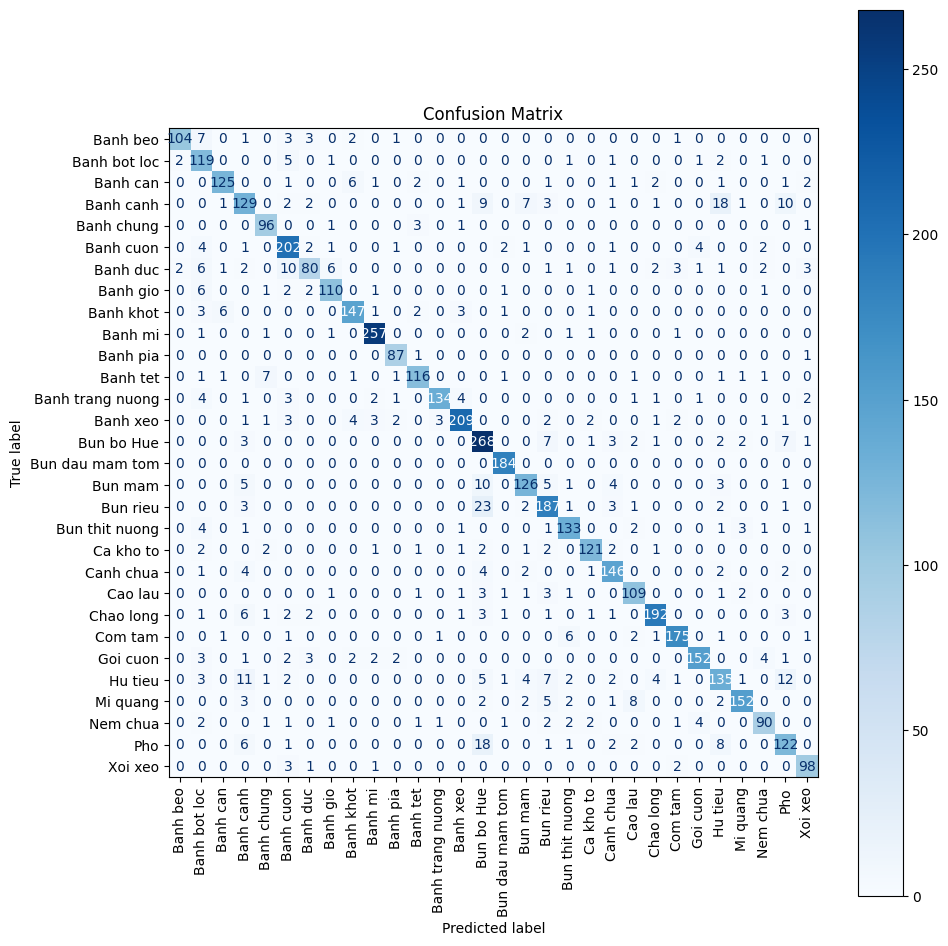

In [13]:
# Dự đoán kết quả trên tập test
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thật từ test_gen
y_true = test_gen.classes

# Lấy tên lớp theo đúng thứ tự
class_names = list(test_gen.class_indices.keys())

# In báo cáo phân loại
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Hiển thị confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [14]:
# Lấy đường dẫn ảnh từ generator
filepaths = test_gen.filepaths

# Lấy ánh xạ từ số -> tên món (label)
class_indices = test_gen.class_indices  # {'banh_nam': 0, 'banh_beo': 1, ...}
labels = dict((v, k) for k, v in class_indices.items())  # {0: 'banh_nam', 1: 'banh_beo', ...}

# Lặp qua và in ra các ảnh bị đoán sai, kèm nhãn thật và nhãn dự đoán
print("\nCác ảnh bị đoán sai:")
for i in range(len(y_true)):
    if y_pred_classes[i] != y_true[i]:
        true_label = labels[y_true[i]]
        pred_label = labels[y_pred_classes[i]]
        print(f"Sai: {filepaths[i]} | Thật: {true_label} | Đoán: {pred_label}")



Các ảnh bị đoán sai:
Sai: /content/Images/Test/Banh beo/51.jpg | Thật: Banh beo | Đoán: Banh pia
Sai: /content/Images/Test/Banh beo/554.jpg | Thật: Banh beo | Đoán: Banh bot loc
Sai: /content/Images/Test/Banh beo/526.jpg | Thật: Banh beo | Đoán: Com tam
Sai: /content/Images/Test/Banh beo/394.jpg | Thật: Banh beo | Đoán: Banh khot
Sai: /content/Images/Test/Banh beo/567.jpg | Thật: Banh beo | Đoán: Banh bot loc
Sai: /content/Images/Test/Banh beo/323.jpg | Thật: Banh beo | Đoán: Banh duc
Sai: /content/Images/Test/Banh beo/513.jpg | Thật: Banh beo | Đoán: Banh cuon
Sai: /content/Images/Test/Banh beo/588.jpg | Thật: Banh beo | Đoán: Banh khot
Sai: /content/Images/Test/Banh beo/281.jpg | Thật: Banh beo | Đoán: Banh canh
Sai: /content/Images/Test/Banh beo/212.jpg | Thật: Banh beo | Đoán: Banh cuon
Sai: /content/Images/Test/Banh beo/79.jpg | Thật: Banh beo | Đoán: Banh bot loc
Sai: /content/Images/Test/Banh beo/270.jpg | Thật: Banh beo | Đoán: Banh bot loc
Sai: /content/Images/Test/Banh beo/2

In [15]:
# Lưu mô hình tốt nhất sau khi huấn luyện
model.save("/content/drive/MyDrive/FOOD30V2/final/DenseNet169.h5")
print("\nĐã lưu mô hình cuối cùng!")


Đã lưu mô hình cuối cùng!


In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Load mô hình đã lưu
model = load_model("/content/drive/MyDrive/FOOD30V2/final/DenseNet169.h5", custom_objects={'CBAM': CBAM})

# Danh sách tên lớp
class_names = list(train_gen.class_indices.keys())

# Kích thước ảnh input
img_size = 224

def predict_image(image_path):
    # Load ảnh và resize
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Dự đoán
    predictions = model.predict(img_array)[0]  # lấy mảng 1 chiều
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = np.max(predictions) * 100

    # Hiển thị ảnh và kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Dự đoán: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    # In ra xác suất từng lớp
    print(f"\nẢnh {image_path.split('/')[-1]}: Xác suất các lớp:")
    for class_name, prob in zip(class_names, predictions):
        print(f"{class_name}: {prob * 100:.2f}%")


Saving 29.jpg to 29.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


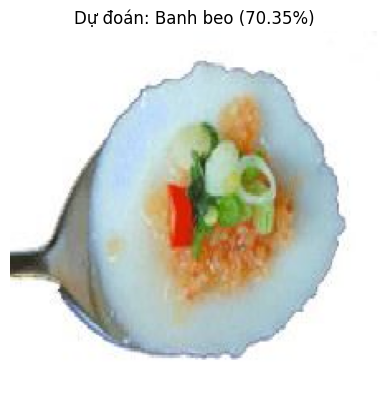


Ảnh 29.jpg: Xác suất các lớp:
Banh beo: 70.35%
Banh bot loc: 7.37%
Banh can: 0.00%
Banh canh: 0.26%
Banh chung: 0.01%
Banh cuon: 0.00%
Banh duc: 1.36%
Banh gio: 15.83%
Banh khot: 0.05%
Banh mi: 0.24%
Banh pia: 0.18%
Banh tet: 1.96%
Banh trang nuong: 0.00%
Banh xeo: 0.01%
Bun bo Hue: 0.01%
Bun dau mam tom: 0.00%
Bun mam: 0.03%
Bun rieu: 0.01%
Bun thit nuong: 0.01%
Ca kho to: 0.14%
Canh chua: 1.40%
Cao lau: 0.00%
Chao long: 0.08%
Com tam: 0.26%
Goi cuon: 0.05%
Hu tieu: 0.35%
Mi quang: 0.00%
Nem chua: 0.00%
Pho: 0.00%
Xoi xeo: 0.02%


In [17]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
filepath = "/content/" + filename
predict_image(filepath)

155/155 ━━━━━━━━━━━━━━━━━━━━ 89s 485ms/step

Classification Report:
                  precision    recall  f1-score   support

        Banh beo       0.96      0.85      0.90       122
    Banh bot loc       0.71      0.89      0.79       133
        Banh can       0.93      0.86      0.89       145
       Banh canh       0.72      0.70      0.71       185
      Banh chung       0.86      0.94      0.90       102
       Banh cuon       0.83      0.91      0.87       221
        Banh duc       0.84      0.66      0.74       122
        Banh gio       0.90      0.88      0.89       125
       Banh khot       0.91      0.90      0.90       164
         Banh mi       0.96      0.97      0.96       265
        Banh pia       0.92      0.98      0.95        89
        Banh tet       0.91      0.88      0.90       132
Banh trang nuong       0.96      0.87      0.91       154
        Banh xeo       0.94      0.89      0.91       235
      Bun bo Hue       0.77      0.90      0.83       297
 Bu

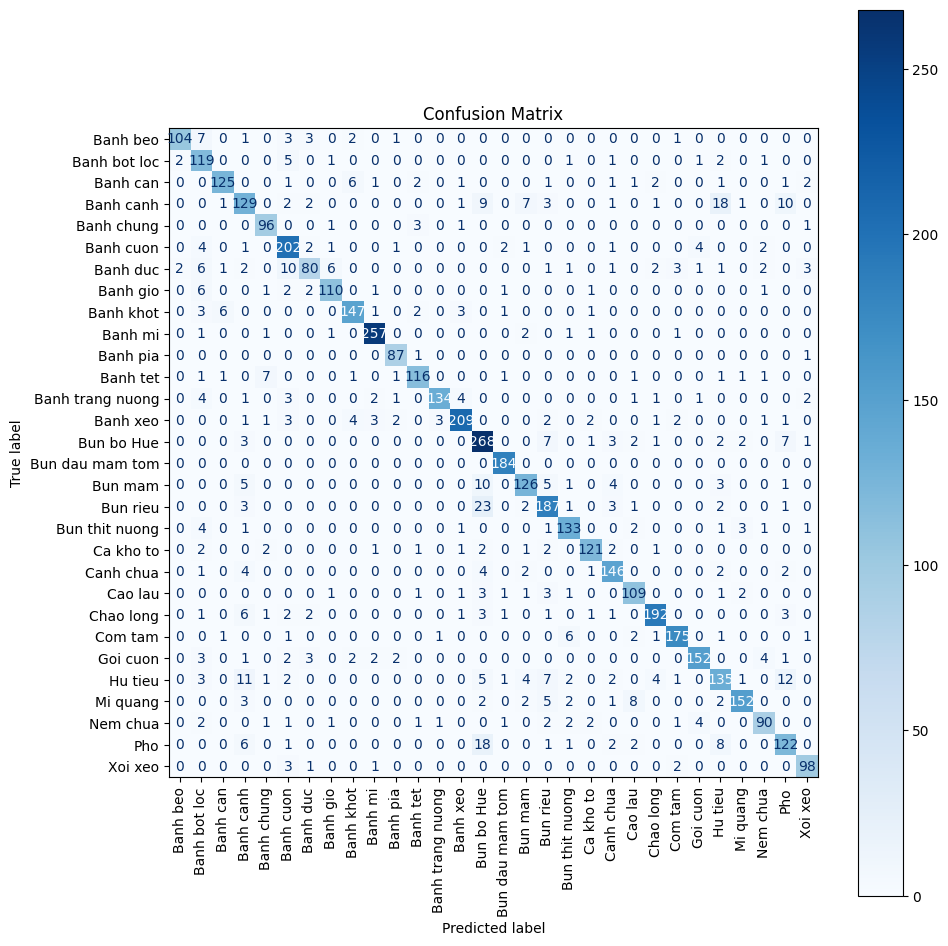

In [18]:
# Load mô hình đã lưu
model = load_model("/content/drive/MyDrive/FOOD30V2/final/DenseNet169.h5", custom_objects={'CBAM': CBAM})

y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thật từ test_gen
y_true = test_gen.classes

# Lấy tên lớp theo đúng thứ tự
class_names = list(test_gen.class_indices.keys())

# In báo cáo phân loại
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Hiển thị confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
